In [1]:
import os
import json
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

paths = {
    # "Pythia 2.8b-AX-sft": "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/experiment_5/inference/ContextualAI/archangel_kto_pythia2-8b/MMLU/hendrycks*/0-shot/results.json",
    "Pythia 2.8b": "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/experiment_5/inference/EleutherAI/pythia-2.8b/MMLU/hendrycks*/0-shot/results.json",
    # "OLMo-7B-SFT": "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/experiment_5/inference/allenai/OLMo-7B-SFT/MMLU/hendrycks*/0-shot/results.json",
    # "OLMo-7B": "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/experiment_5/inference/allenai/OLMo-7B/MMLU/hendrycks*/0-shot/results.json",
    "Pythia 6.9b": "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/experiment_5/inference/EleutherAI/pythia-2.8b/MMLU/hendrycks*/0-shot/results.json",
    "Pythia 6.9b tulu": "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/experiment_5/inference/allenai/open-instruct-pythia-6.9b-tulu/MMLU/hendrycks*/0-shot/results.json"
}

In [21]:
def load_result(path):
    with open(path, 'r') as file:
        result = json.load(file)['results']
    return result

def calculate_mean_acc(results):
    total_acc = 0
    count = 0
    for category, metrics in results.items():
        if 'acc' in metrics:
            total_acc += metrics['acc']
            count += 1
    mean_acc = total_acc / count if count else 0
    return round(mean_acc, 3)

def sort_tasks_by_accuracy_diff(data, tasks, models):
    diffs = []
    for task in tasks:
        accuracies = [data[model][task]['acc'] for model in models]
        diff = max(accuracies) - min(accuracies)
        diffs.append(diff)
    sorted_indices = np.argsort(diffs)[::-1]
    sorted_tasks = [tasks[i] for i in sorted_indices]
    return sorted_tasks, sorted_indices

def sort_taks_by_accuracy(data, tasks):
    accuracies = [data[task]['acc'] for task in tasks]
    sorted_indices = np.argsort(accuracies)[::-1]
    sorted_tasks = [tasks[i] for i in sorted_indices]
    return sorted_tasks, sorted_indices

def plot_bar_chart(data, title=None):
    models = list(data.keys())
    accuracies = list(data.values())

    # Sort the data based on accuracies in ascending order
    sorted_data = sorted(zip(models, accuracies), key=lambda x: x[1])
    sorted_models, sorted_accuracies = zip(*sorted_data)

    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.6
    opacity = 0.8

    ax.bar(sorted_models, sorted_accuracies, bar_width, alpha=opacity)

    # Add value labels on top of each bar
    for i, v in enumerate(sorted_accuracies):
        ax.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=10)

    ax.set_ylim(0, max(sorted_accuracies) + 0.1)  # Set y-axis limits for better visibility
    ax.set_xlabel('Models')
    ax.set_ylabel('Accuracy')
    if title:
        ax.set_title(title)
    else:
        ax.set_title('Model Comparison')
    ax.set_xticklabels(sorted_models, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

def plot_model_comparison(data, sort_by_diff=False):
    remove_strings = ['hendrycksTest-']

    models = list(data.keys())
    tasks = list(data[models[0]].keys())
    num_models = len(models)
    num_tasks = len(tasks)

    cleaned_tasks = []
    for task in tasks:
        cleaned_task = task
        for string_to_remove in remove_strings:
            cleaned_task = cleaned_task.replace(string_to_remove, '')
        cleaned_tasks.append(cleaned_task)

    if sort_by_diff:
        sorted_tasks, sorted_indices = sort_tasks_by_accuracy_diff(data, tasks, models)
        cleaned_tasks = [cleaned_tasks[i] for i in sorted_indices]
        tasks = sorted_tasks

    fig, ax = plt.subplots(figsize=(15, 8))
    bar_width = 1. / num_models
    opacity = 1

    for i, model in enumerate(models):
        model_data = [data[model][task]['acc'] for task in tasks]
        index = np.arange(num_tasks)
        pos = index + i * bar_width

        ax.bar(pos, model_data, bar_width, alpha=opacity, label=model)

        # Calculate and display average performance for each model
        avg_performance = np.mean(model_data)
        ax.annotate(f"{model}: {avg_performance:.2f}", xy=(num_tasks - 0.5, avg_performance),
                    xytext=(0, 5 + i * 20), textcoords="offset points", ha='right', va='bottom')

    ax.set_xlabel('Tasks')
    ax.set_ylabel('Accuracy')
    ax.set_title('Model Comparison')
    ax.set_xticks(index + bar_width * (num_models - 1) / 2)
    ax.set_xticklabels(cleaned_tasks, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

results = {model: load_result(path) for model, path in paths.items()}
mean_accs = {model: calculate_mean_acc(result) for model, result in results.items()}

models = list(results.keys())
tasks = list(results[models[0]].keys())
sorted_task_diffs, sorted_task_diff_indices = sort_tasks_by_accuracy_diff(results, tasks, models)
sorted_task_accs, sorted_task_acc_indices = sort_taks_by_accuracy(results['Pythia 6.9b tulu'], tasks)

mean_accs

{'Pythia 2.8b': 0.253, 'Pythia 6.9b': 0.253, 'Pythia 6.9b tulu': 0.322}

In [24]:
top_20 = sorted_task_accs[:20]

for task in top_20:
    print(task, results['Pythia 6.9b tulu'][task]['acc'])

hendrycksTest-high_school_world_history 0.4641350210970464
hendrycksTest-high_school_us_history 0.45098039215686275
hendrycksTest-computer_security 0.44
hendrycksTest-marketing 0.4358974358974359
hendrycksTest-miscellaneous 0.42911877394636017
hendrycksTest-human_aging 0.4260089686098655
hendrycksTest-high_school_european_history 0.3939393939393939
hendrycksTest-global_facts 0.39
hendrycksTest-anatomy 0.3851851851851852
hendrycksTest-logical_fallacies 0.3803680981595092
hendrycksTest-high_school_psychology 0.3798165137614679
hendrycksTest-management 0.3786407766990291
hendrycksTest-high_school_government_and_politics 0.37823834196891193
hendrycksTest-astronomy 0.375
hendrycksTest-virology 0.3674698795180723
hendrycksTest-public_relations 0.36363636363636365
hendrycksTest-professional_psychology 0.35947712418300654
hendrycksTest-conceptual_physics 0.3574468085106383
hendrycksTest-international_law 0.35537190082644626
hendrycksTest-nutrition 0.34967320261437906


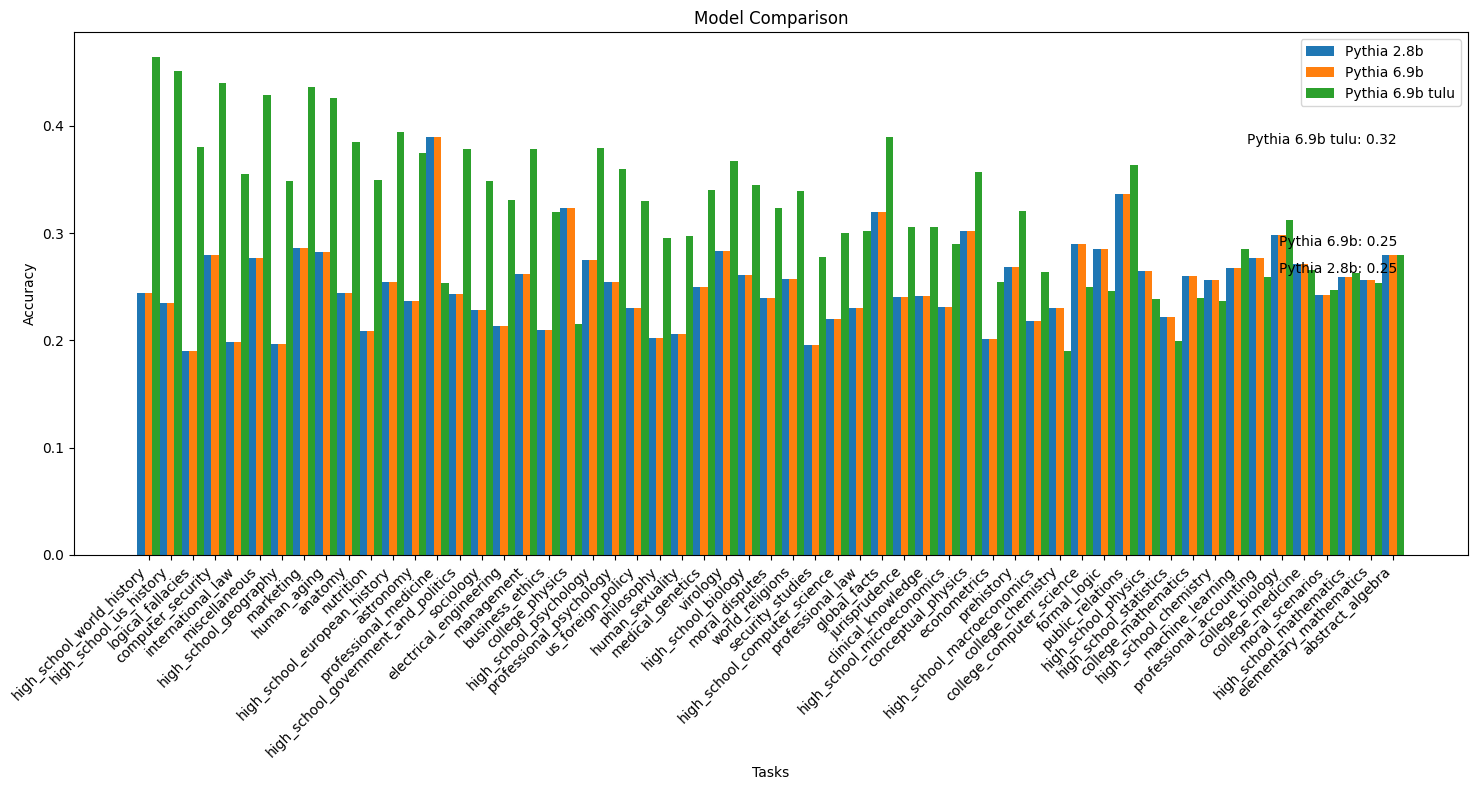

In [4]:
plot_model_comparison(results, True)

In [5]:
mean_accs

{'Pythia 2.8b': 0.253, 'Pythia 6.9b': 0.253, 'Pythia 6.9b tulu': 0.322}

/tmp/ipykernel_190279/1905221088.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sorted_models, rotation=45, ha='right')


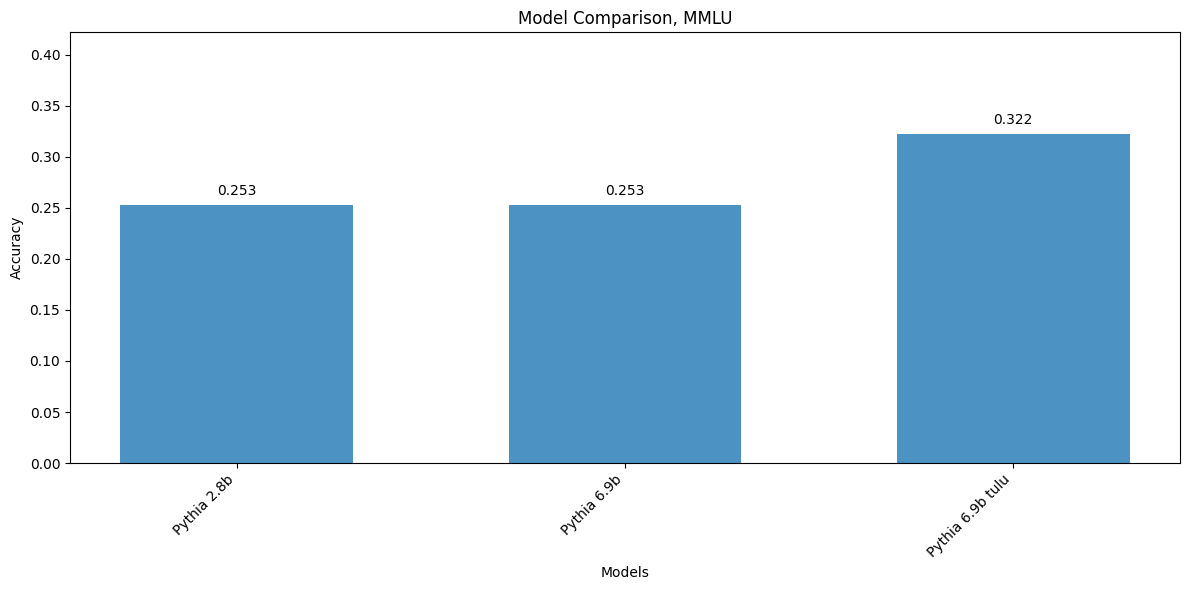

In [6]:
plot_bar_chart(mean_accs,
               title="Model Comparison, MMLU")